# Assignment 4 — MMA 823 — Team 5


## Question 1:  

Pick a stock of your choice, perform the following tasks. 

#### 1. Download the stock closing price from Jan 1, 2020 – Dec 31, 2024 and show the price graph

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-02 to 2024-12-30
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (close, TSLA)  1257 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB
None
Price           close
Ticker           TSLA
Date                 
2020-01-02  28.684000
2020-01-03  29.534000
2020-01-06  30.102667
2020-01-07  31.270666
2020-01-08  32.809334


<Figure size 1200x600 with 0 Axes>

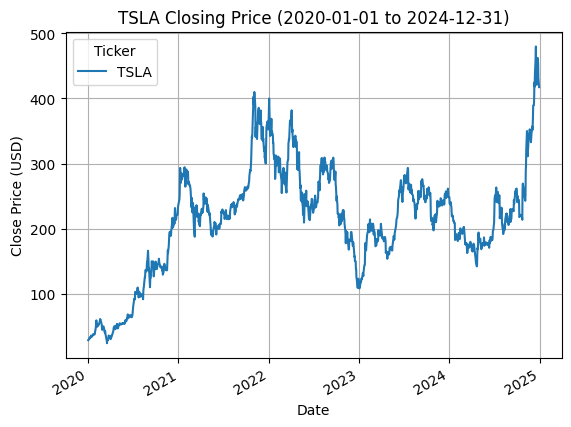

In [2]:
import yfinance as yf
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Download TSLA daily data for the period
tsla = yf.download("TSLA", start="2020-01-01", end="2024-12-31", progress=False)

# Keep only the closing price and rename for convenience
tsla = tsla[['Close']].rename(columns={'Close': 'close'})

# Quick check
print(tsla.info())
print(tsla.head())

# Plot closing price
plt.figure(figsize=(12, 6))
tsla['close'].plot(title='TSLA Closing Price (2020-01-01 to 2024-12-31)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

#### 2. Construct the 10-, 20-, and 60-day moving averages (you should try both simple moving average and exponentially weighted moving averages). Use the averages to identify some of the trading (buy/sell) opportunities. Discuss your findings.

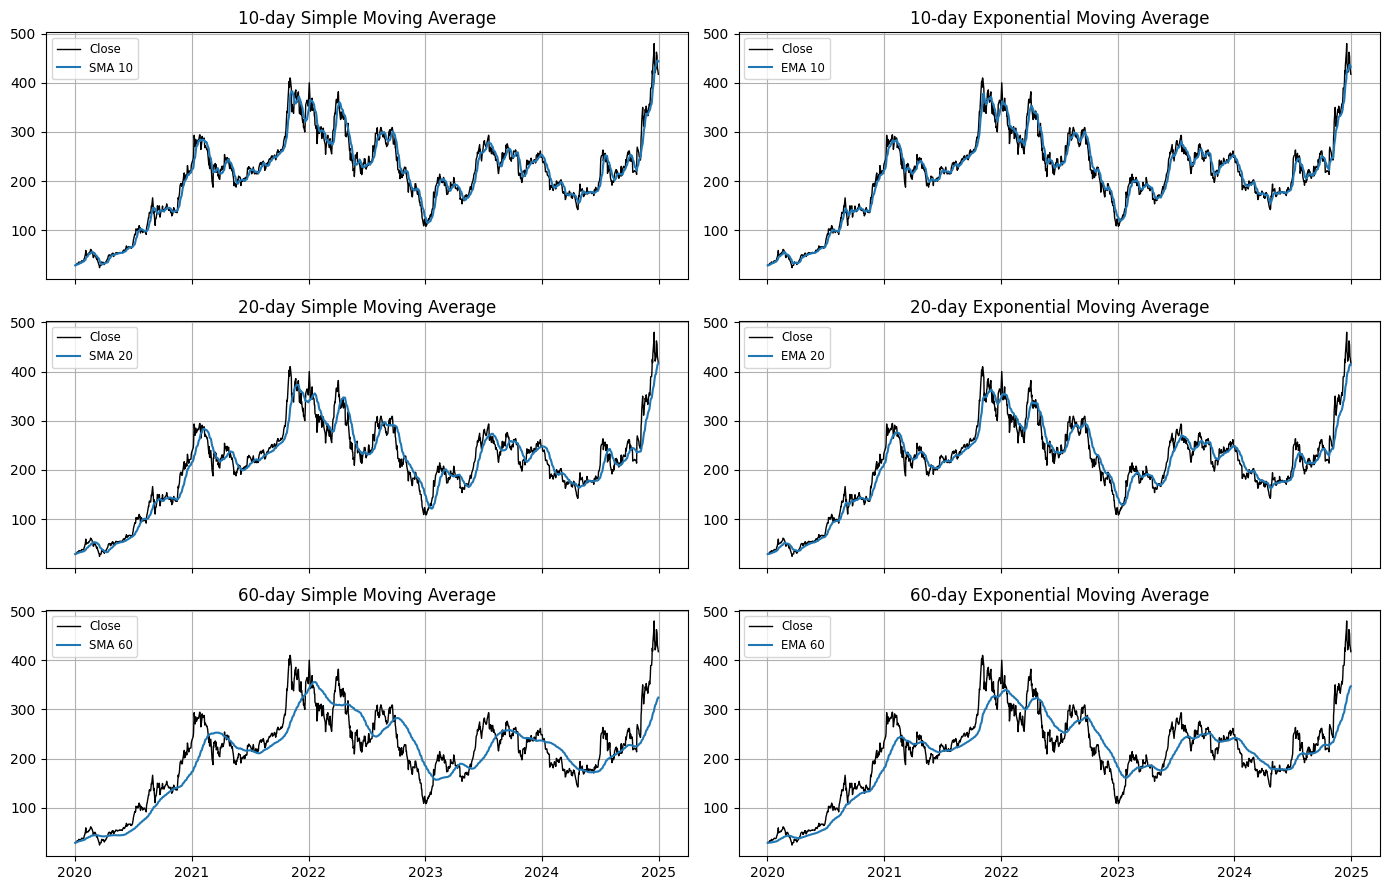

In [3]:
# Construct 10-, 20-, and 60-day SMAs and EMAs for the existing `tsla` DataFrame
# and plot them in a compact 3x2 grid (SMA on left, EMA on right for each window).

# Work on a copy to avoid overwriting the original variable
df_raw = tsla.copy()

# Locate the close price column robustly (handles plain, different names, or MultiIndex)
if 'close' in df_raw.columns:
    price = df_raw['close']
else:
    found = None
    for col in df_raw.columns:
        if isinstance(col, tuple):
            # check tuple elements for 'close'
            for c in col:
                if isinstance(c, str) and c.lower() == 'close':
                    found = col
                    break
            if found:
                break
        else:
            if str(col).lower() == 'close' or 'close' in str(col).lower():
                found = col
                break
    if found is None:
        # fallback: pick first numeric column
        numeric_cols = df_raw.select_dtypes(include='number').columns
        if len(numeric_cols) == 0:
            raise RuntimeError("Could not locate a numeric 'close' column in `tsla`.")
        found = numeric_cols[0]
    price = df_raw[found]

# Normalize into a single-column DataFrame named 'close'
if hasattr(price, "to_frame") and not isinstance(price, type(tsla)):
    # price is a Series-like object with to_frame
    df = price.to_frame(name='close')
else:
    # price is already a DataFrame (possibly with MultiIndex columns)
    df = price.copy()
    # If multiple columns, pick the first numeric column
    if df.shape[1] > 1:
        numeric_cols = df.select_dtypes(include='number').columns
        col = numeric_cols[0] if len(numeric_cols) else df.columns[0]
        df = df[[col]]
    # Rename the single column to 'close'
    df.columns = ['close']

# Define windows and compute SMAs and EMAs
windows = [10, 20, 60]
for w in windows:
    df[f'SMA_{w}'] = df['close'].rolling(window=w, min_periods=1).mean()
    df[f'EMA_{w}'] = df['close'].ewm(span=w, adjust=False).mean()

# Plot in a 3x2 grid (rows = windows, cols = SMA/EMA)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 9), sharex=True)
for i, w in enumerate(windows):
    ax_sma = axes[i, 0]
    ax_ema = axes[i, 1]

    # SMA plot
    ax_sma.plot(df.index, df['close'], label='Close', color='black', linewidth=1)
    ax_sma.plot(df.index, df[f'SMA_{w}'], label=f'SMA {w}', linewidth=1.5)
    ax_sma.set_title(f'{w}-day Simple Moving Average')
    ax_sma.legend(loc='best', fontsize='small')
    ax_sma.grid(True)

    # EMA plot
    ax_ema.plot(df.index, df['close'], label='Close', color='black', linewidth=1)
    ax_ema.plot(df.index, df[f'EMA_{w}'], label=f'EMA {w}', linewidth=1.5)
    ax_ema.set_title(f'{w}-day Exponential Moving Average')
    ax_ema.legend(loc='best', fontsize='small')
    ax_ema.grid(True)

plt.tight_layout()
plt.show()

The charts show Tesla’s closing price with 10-, 20-, and 60-day simple and exponential moving averages. Short-term averages (10- and 20-day) closely follow price changes and provide faster trading signals: buy opportunities occur when the price or shorter MA crosses above a longer one (bullish crossover), and sell signals occur when it crosses below (bearish crossover). For example, around late 2020 and early 2023, sharp upward crossings of the 10- or 20-day EMA preceded major rallies—strong buy signals. Conversely, in early 2022 and mid-2023, downward crossings of these MAs foreshadowed steep declines—clear sell signals. Longer averages (60-day) smoothed volatility and confirmed sustained trend reversals, making them more reliable for medium-term trades but slower to react.

#### 3. Use Absolute Price Oscillator to repeat your work in 2). Discuss your findings.

APO_10_20: zero-cross buys=21, sells=21; sig-cross buys=48, sells=49
APO_10_60: zero-cross buys=13, sells=13; sig-cross buys=41, sells=42
APO_20_60: zero-cross buys=10, sells=10; sig-cross buys=29, sells=29


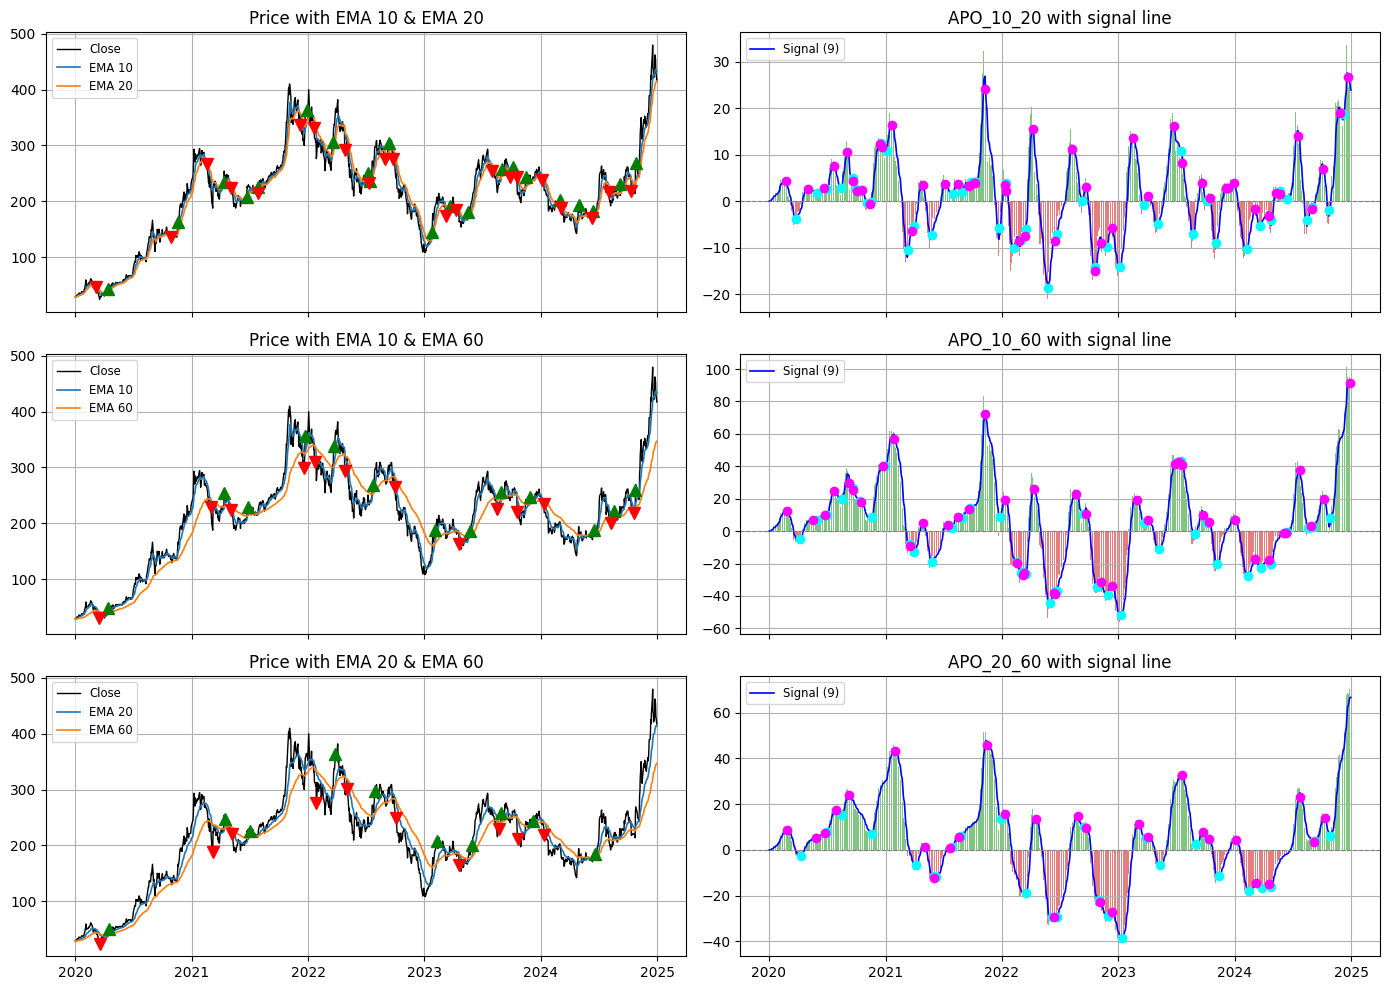


First 10 non-empty signals for APO_10_60:
                 close  APO_10_60  APO_10_60_sig  buy_zero  sell_zero  \
Date                                                                    
2020-02-26   51.919998  12.682565      13.207565     False      False   
2020-03-16   29.671333  -1.526684       3.327302     False       True   
2020-04-06   34.416000  -5.031830      -5.131251     False      False   
2020-04-15   48.655334   1.455718      -2.203526      True      False   
2020-05-19   53.867332   7.132091       7.142315     False      False   
2020-06-01   59.873333   7.146017       6.894069     False      False   
2020-06-24   64.056664   9.953262      10.113512     False      False   
2020-06-30   71.987335   9.955097       9.795190     False      False   
2020-07-24   94.466667  24.963098      25.271817     False      False   
2020-08-17  122.375999  19.698497      17.816015     False      False   

            buy_sig  sell_sig  
Date                           
2020-02-26    Fa

In [ ]:
import numpy as np
import pandas as pd

# Compute Absolute Price Oscillator (APO) variants using existing EMA columns in `df`
# and plot them alongside price + EMAs. Also generate simple trading signals
# using both zero-cross and signal-line-cross methods.


# Define EMA column names present in df
ema_cols = {10: "EMA_10", 20: "EMA_20", 60: "EMA_60"}

pairs = [(10, 20), (10, 60), (20, 60)]
signal_span = 9  # common signal-line span for APO

# Compute APOs and their signal lines
for short, long in pairs:
    apo_name = f"APO_{short}_{long}"
    sig_name = f"{apo_name}_sig"
    df[apo_name] = df[ema_cols[short]] - df[ema_cols[long]]
    df[sig_name] = df[apo_name].ewm(span=signal_span, adjust=False).mean()


# Helper to detect cross events
def detect_crosses(series, level=0.0):
    prev = series.shift(1)
    cross_up = (prev < level) & (series >= level)
    cross_down = (prev > level) & (series <= level)
    return cross_up.fillna(False), cross_down.fillna(False)


def detect_crosses_between(a, b):
    # a crosses above b -> buy, a crosses below b -> sell
    prev_a, prev_b = a.shift(1), b.shift(1)
    cross_up = (prev_a < prev_b) & (a >= b)
    cross_down = (prev_a > prev_b) & (a <= b)
    return cross_up.fillna(False), cross_down.fillna(False)


# Plot results in a 3x2 grid: left = price + EMAs + markers, right = APO + signal + histogram
fig_ap, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), sharex=True)

for i, (short, long) in enumerate(pairs):
    apo_name = f"APO_{short}_{long}"
    sig_name = f"{apo_name}_sig"

    ax_price = axs[i, 0]
    ax_apo = axs[i, 1]

    # Price plot with the two EMAs
    ax_price.plot(df.index, df["close"], label="Close", color="black", linewidth=1)
    ax_price.plot(df.index, df[ema_cols[short]], label=f"EMA {short}", linewidth=1.2)
    ax_price.plot(df.index, df[ema_cols[long]], label=f"EMA {long}", linewidth=1.2)
    ax_price.set_title(f"Price with EMA {short} & EMA {long}")
    ax_price.legend(loc="best", fontsize="small")
    ax_price.grid(True)

    # Signals based on APO zero-cross
    buy_z, sell_z = detect_crosses(df[apo_name], level=0.0)

    # Signals based on APO crossing its signal-line
    buy_sig, sell_sig = detect_crosses_between(df[apo_name], df[sig_name])

    # Plot buy/sell markers on price (zero-cross method as primary)
    ax_price.plot(
        df.index[buy_z],
        df["close"][buy_z],
        "^",
        color="green",
        markersize=8,
        label="Buy (APO zero)",
    )
    ax_price.plot(
        df.index[sell_z],
        df["close"][sell_z],
        "v",
        color="red",
        markersize=8,
        label="Sell (APO zero)",
    )

    # APO plot: histogram + signal line
    ax_apo.bar(
        df.index,
        df[apo_name],
        width=1.0,
        color=np.where(df[apo_name] >= 0, "#2ca02c", "#d62728"),
        alpha=0.6,
    )
    ax_apo.plot(
        df.index,
        df[sig_name],
        color="blue",
        linewidth=1.2,
        label=f"Signal ({signal_span})",
    )
    ax_apo.axhline(0, color="gray", linewidth=0.8, linestyle="--")
    ax_apo.set_title(f"{apo_name} with signal line")
    ax_apo.legend(loc="best", fontsize="small")
    ax_apo.grid(True)

    # Also mark signal-line cross events on APO plot
    ax_apo.plot(
        df.index[buy_sig],
        df[apo_name][buy_sig],
        "o",
        color="cyan",
        markersize=6,
        label="Buy (APO>sig)",
    )
    ax_apo.plot(
        df.index[sell_sig],
        df[apo_name][sell_sig],
        "o",
        color="magenta",
        markersize=6,
        label="Sell (APO<sig)",
    )

    # Print quick summary counts for this pair (in notebook output)
    print(
        f"{apo_name}: zero-cross buys={buy_z.sum()}, sells={sell_z.sum()}; sig-cross buys={buy_sig.sum()}, sells={sell_sig.sum()}"
    )

# Improve layout
plt.tight_layout()
plt.show()

# Example: produce a small table of first few signals for the 10-60 APO (inspectable in notebook)
apo_example = "APO_10_60"
sig_example = f"{apo_example}_sig"
zc_buy, zc_sell = detect_crosses(df[apo_example], 0.0)
sig_buy, sig_sell = detect_crosses_between(df[apo_example], df[sig_example])

signals_df = pd.DataFrame(
    {
        "close": df["close"],
        apo_example: df[apo_example],
        sig_example: df[sig_example],
        "buy_zero": zc_buy,
        "sell_zero": zc_sell,
        "buy_sig": sig_buy,
        "sell_sig": sig_sell,
    }
)

# Show first 10 signal rows
print("\nFirst 10 non-empty signals for APO_10_60:")
print(
    signals_df[
        signals_df[["buy_zero", "sell_zero", "buy_sig", "sell_sig"]].any(axis=1)
    ].head(10)
)

The Tesla Absolute Price Oscillator (APO) charts illustrate trading signals derived from differences between short- and long-term EMAs. In each case, buy signals occur when the APO crosses above zero (short-term EMA rises above the long-term EMA), and sell signals occur when it crosses below zero. The 10–20 EMA pairing generates frequent signals, ideal for short-term trades but prone to false moves in sideways markets. The 10–60 and 20–60 combinations filter out noise, producing fewer but more reliable signals—particularly effective during Tesla’s large trend shifts in late 2020, early 2022, and late 2023. These crossovers aligned with major rallies and corrections, suggesting that longer lookback APOs provide stronger confirmation of sustained momentum changes.


#### 4. Use Bollinger band (the different time moving windows) to repeat your work in 2).

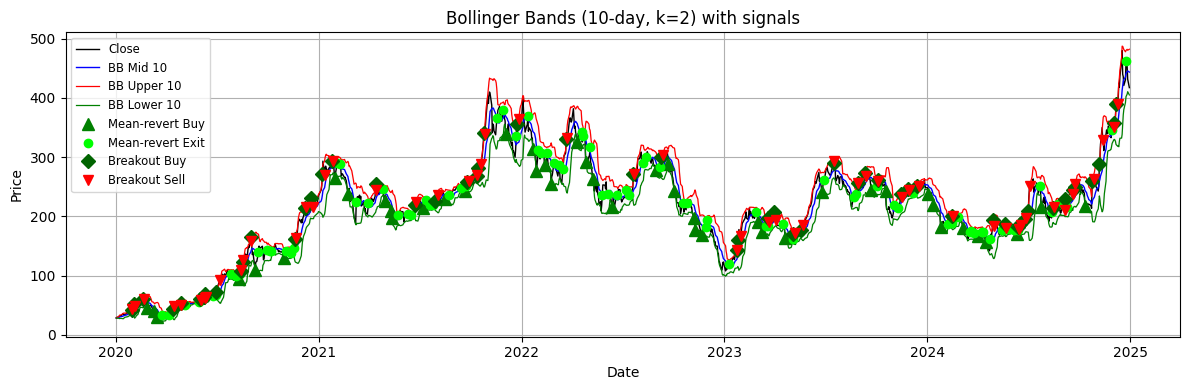

Window 10: mean-revert buys=44, mean-revert exits=98, breakout buys=56, breakout sells=56

First 8 BB signal rows for window 10:


,close,BB_mid_10,BB_upper_10,BB_lower_10,BB_pctb_10,BB_buy_mean_10,BB_exit_mean_10,BB_buy_break_10,BB_sell_break_10
Date,,,,,,,,,
2020-01-30,42.720669,37.496600,42.116005,32.877195,1.065448,False,False,True,False
2020-01-31,43.371334,38.410467,43.658513,33.162421,0.972639,False,False,False,True
2020-02-03,52.000000,40.207133,49.198039,31.216228,1.155822,False,False,True,False
2020-02-05,48.980000,43.573800,57.788846,29.358753,0.690158,False,False,False,True
2020-02-19,61.161331,52.830200,59.980833,45.679567,1.082545,False,False,True,False
2020-02-20,59.960667,53.928267,61.720336,46.136197,0.887086,False,False,False,True
2020-02-27,45.266666,55.145066,64.202338,46.087794,-0.045330,True,False,False,False
2020-03-09,40.533333,48.002333,55.200544,40.804122,-0.018809,True,False,False,False


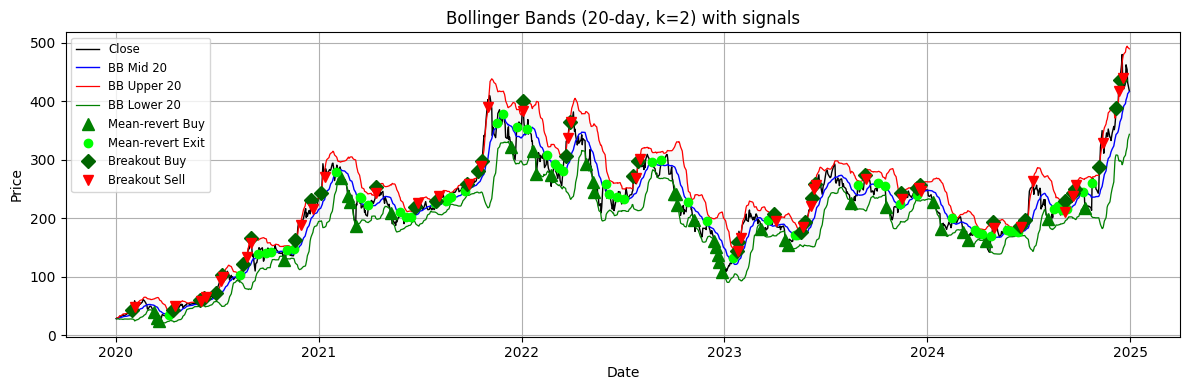

Window 20: mean-revert buys=37, mean-revert exits=59, breakout buys=42, breakout sells=42

First 8 BB signal rows for window 20:


,close,BB_mid_20,BB_upper_20,BB_lower_20,BB_pctb_20,BB_buy_mean_20,BB_exit_mean_20,BB_buy_break_20,BB_sell_break_20
Date,,,,,,,,,
2020-01-30,42.720669,34.837566,41.862756,27.812377,1.061060,False,False,True,False
2020-02-05,48.980000,39.032433,52.827747,25.237119,0.860541,False,False,False,True
2020-03-09,40.533333,51.757833,62.210261,41.305405,-0.036933,True,False,False,False
2020-03-16,29.671333,48.140566,64.715955,31.565178,-0.057128,True,False,False,False
2020-03-18,24.081333,44.859233,64.166420,25.552046,-0.038087,True,False,False,False
2020-04-06,34.416000,33.192867,42.288214,24.097520,0.567240,False,True,False,False
2020-04-13,43.396667,32.964567,41.404186,24.524948,1.118043,False,False,True,False
2020-04-17,50.259335,37.213534,50.615665,23.811403,0.986706,False,False,False,True


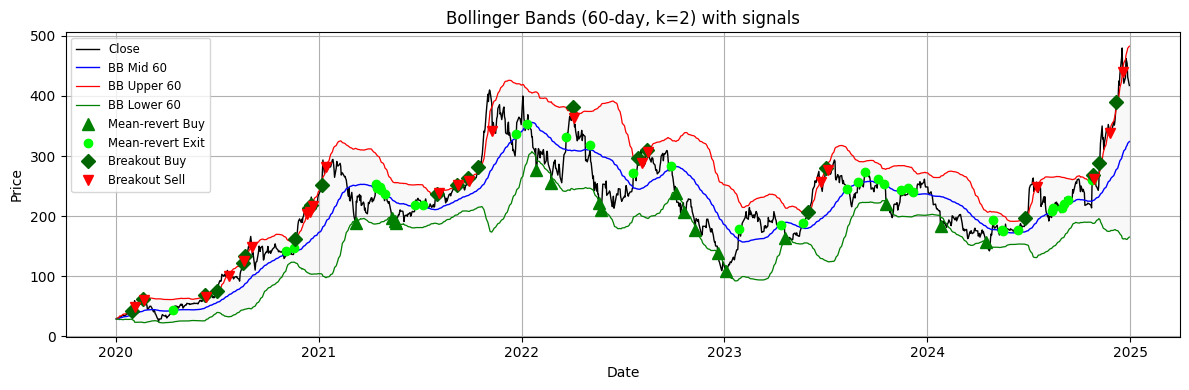

Window 60: mean-revert buys=17, mean-revert exits=37, breakout buys=23, breakout sells=23

First 8 BB signal rows for window 60:


,close,BB_mid_60,BB_upper_60,BB_lower_60,BB_pctb_60,BB_buy_mean_60,BB_exit_mean_60,BB_buy_break_60,BB_sell_break_60
Date,,,,,,,,,
2020-01-30,42.720669,34.837566,41.862756,27.812377,1.061060,False,False,True,False
2020-02-05,48.980000,37.510000,51.846563,23.173437,0.900026,False,False,False,True
2020-02-19,61.161331,41.804909,60.771704,22.838114,1.010271,False,False,True,False
2020-02-20,59.960667,42.338902,62.006091,22.671712,0.947999,False,False,False,True
2020-04-13,43.396667,42.197000,61.022366,23.371634,0.531863,False,True,False,False
2020-06-10,68.336670,47.162400,68.287072,26.037728,1.001174,False,False,True,False
2020-06-11,64.856003,47.765333,68.810411,26.720256,0.906049,False,False,False,True
2020-07-01,74.641998,55.899289,72.561927,39.236651,1.062417,False,False,True,False


In [5]:
# Bollinger Bands analysis (10-, 20-, 60-day) with simple mean-reversion and breakout signals.
# Reuses existing `df`, `windows`, and helper functions already defined in the notebook.

k = 2  # number of std devs for bands
bb_windows = windows  # [10, 20, 60]

for w in bb_windows:
    mid_col = f"BB_mid_{w}"
    std_col = f"BB_std_{w}"
    upper_col = f"BB_upper_{w}"
    lower_col = f"BB_lower_{w}"
    pctb_col = f"BB_pctb_{w}"

    # Compute bands
    df[mid_col] = df["close"].rolling(window=w, min_periods=1).mean()
    df[std_col] = df["close"].rolling(window=w, min_periods=1).std(ddof=0).fillna(0)
    df[upper_col] = df[mid_col] + k * df[std_col]
    df[lower_col] = df[mid_col] - k * df[std_col]
    df[pctb_col] = (df["close"] - df[lower_col]) / (
        df[upper_col] - df[lower_col]
    ).replace(0, np.nan)

    # Signals
    # Breakout strategy: buy when price crosses above upper, exit when price crosses back below mid
    buy_break, sell_break = detect_crosses_between(df["close"], df[upper_col])
    exit_break, _ = detect_crosses_between(
        df["close"], df[mid_col]
    )  # cross above mid -> exit long from lower break or breakout exit

    # Mean-reversion strategy: buy when price crosses below lower, exit when price crosses above mid
    _, buy_mean = detect_crosses_between(
        df["close"], df[lower_col]
    )  # cross down below lower -> buy
    exit_mean, _ = detect_crosses_between(
        df["close"], df[mid_col]
    )  # cross up above mid -> exit

    # Save signals to df
    df[f"BB_buy_break_{w}"] = buy_break
    df[f"BB_sell_break_{w}"] = sell_break
    df[f"BB_exit_break_{w}"] = exit_break

    df[f"BB_buy_mean_{w}"] = buy_mean
    df[f"BB_exit_mean_{w}"] = exit_mean

    # Plot price with bands and mark signals
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df.index, df["close"], label="Close", color="black", linewidth=1)
    ax.plot(df.index, df[mid_col], label=f"BB Mid {w}", color="blue", linewidth=1)
    ax.plot(df.index, df[upper_col], label=f"BB Upper {w}", color="red", linewidth=0.9)
    ax.plot(
        df.index, df[lower_col], label=f"BB Lower {w}", color="green", linewidth=0.9
    )
    ax.fill_between(df.index, df[lower_col], df[upper_col], color="gray", alpha=0.05)

    # Mark mean-reversion buys/exits
    ax.plot(
        df.index[df[f"BB_buy_mean_{w}"]],
        df["close"][df[f"BB_buy_mean_{w}"]],
        "^",
        color="green",
        markersize=8,
        label="Mean-revert Buy",
    )
    ax.plot(
        df.index[df[f"BB_exit_mean_{w}"]],
        df["close"][df[f"BB_exit_mean_{w}"]],
        "o",
        color="lime",
        markersize=6,
        label="Mean-revert Exit",
    )

    # Mark breakout buys/sells
    ax.plot(
        df.index[df[f"BB_buy_break_{w}"]],
        df["close"][df[f"BB_buy_break_{w}"]],
        "D",
        color="darkgreen",
        markersize=7,
        label="Breakout Buy",
    )
    ax.plot(
        df.index[df[f"BB_sell_break_{w}"]],
        df["close"][df[f"BB_sell_break_{w}"]],
        "v",
        color="red",
        markersize=7,
        label="Breakout Sell",
    )

    ax.set_title(f"Bollinger Bands ({w}-day, k={k}) with signals")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True)
    ax.legend(loc="best", fontsize="small")
    plt.tight_layout()
    plt.show()

    # Print concise summary
    print(
        f'Window {w}: mean-revert buys={df[f"BB_buy_mean_{w}"].sum()}, mean-revert exits={df[f"BB_exit_mean_{w}"].sum()}, '
        f'breakout buys={df[f"BB_buy_break_{w}"].sum()}, breakout sells={df[f"BB_sell_break_{w}"].sum()}'
    )

    # Show first few rows where any BB signal fired for inspection
    sig_cols = [
        f"BB_buy_mean_{w}",
        f"BB_exit_mean_{w}",
        f"BB_buy_break_{w}",
        f"BB_sell_break_{w}",
    ]

    example = df[["close", mid_col, upper_col, lower_col, pctb_col] + sig_cols]
    print(f"\nFirst 8 BB signal rows for window {w}:")
    display(example[example[sig_cols].any(axis=1)].head(8))

The Bollinger Bands chart (60-day, k=2) shows Tesla’s price oscillating around its moving average with upper and lower volatility envelopes. Mean-reversion buy signals occur when price touches or dips below the lower band, often preceding rebounds—as seen in mid-2021, mid-2022, and mid-2023. Conversely, breakout buys occur when price pierces the upper band during strong upward momentum, such as in late 2020 and late 2024, signaling sustained rallies. Breakout sells appear when price reverses from the upper band, marking potential trend exhaustion—visible in early 2021 and early 2022. Overall, the bands effectively identify volatility extremes: mean-reversion trades work best in sideways markets, while breakout signals capture momentum shifts during trending periods.


#### 5. Construct the Relative Strength Indicator.

In [6]:
# Simple 14-period RSI using rolling (simple) averages of gains and losses
# (no Wilder smoothing)
period = 14

# period is already defined above (14)
delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Simple moving averages of gains/losses
avg_gain = gain.rolling(window=period, min_periods=period).mean()
avg_loss = loss.rolling(window=period, min_periods=period).mean()

# Relative Strength and RSI
rs = avg_gain / avg_loss.replace(0, np.nan)
rsi = 100 - (100 / (1 + rs))

# Handle edge cases:
# - If avg_loss == 0 and avg_gain > 0 => RSI = 100
# - If avg_gain == 0 and avg_loss > 0 => RSI = 0
rsi.loc[(avg_loss == 0) & (avg_gain > 0)] = 100
rsi.loc[(avg_gain == 0) & (avg_loss > 0)] = 0

# Keep initial NaNs for the first (period-1) rows where rolling window is incomplete
df['RSI_14'] = rsi

# Print concise view
print("RSI_14 — last 10 non-null values:")
print(df['RSI_14'].dropna().tail(10))

print("\nRSI_14 summary statistics:")
print(df['RSI_14'].describe())

RSI_14 — last 10 non-null values:
Date
2024-12-16    88.760850
2024-12-17    90.010751
2024-12-18    75.366650
2024-12-19    72.408544
2024-12-20    65.507886
2024-12-23    68.841618
2024-12-24    72.174769
2024-12-26    68.250827
2024-12-27    59.044415
2024-12-30    55.561821
Name: RSI_14, dtype: float64

RSI_14 summary statistics:
count    1243.000000
mean       53.424045
std        18.806090
min         6.919326
25%        40.546037
50%        53.301733
75%        66.896640
max        97.529933
Name: RSI_14, dtype: float64


## Question 2:

This question is based on the pair trading example shown in class. You can copy-paste the parts from the example code. Make sure you give adequate discussion of each steps of the implementation.

#### 1. Pick 10 stocks, download their historical prices from 2014-2024.

In [7]:
# Download weekly closing prices (2014-01-01 to 2024-12-31) for the selected tickers.
# Assumes `yf` and `pd` are already available in the notebook environment.

tickers = ['KO', 'PEP', 'F', 'GM', 'JPM', 'BAC', 'V', 'MA', 'XOM', 'CVX']

weekly_close = pd.DataFrame()

for t in tickers:
    try:
        data = yf.download(t, start="2014-01-01", end="2024-12-31", interval="1wk", progress=False)
        if data.empty:
            print(f"Warning: no data for {t}")
            continue
        # Prefer explicit 'Close' column; fallback to first numeric column if layout differs
        if 'Close' in data.columns:
            weekly_close[t] = data['Close']
        else:
            numeric_cols = data.select_dtypes(include='number').columns
            weekly_close[t] = data[numeric_cols[0]]
    except Exception as e:
        print(f"Error downloading {t}: {e}")


# Clean up: drop rows where all tickers are NaN (e.g., outside trading ranges)
weekly_close.dropna(how='all', inplace=True)
weekly_close.index.name = 'Date'

# Quick inspection
print("Weekly close (2014-2024) — shape:", weekly_close.shape)
print(weekly_close.info())
print("\nHead:")
print(weekly_close.head())
print("\nTail:")
print(weekly_close.tail())

data=weekly_close.loc[:,tickers]

Weekly close (2014-2024) — shape: (574, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 574 entries, 2014-01-01 to 2024-12-25
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KO      574 non-null    float64
 1   PEP     574 non-null    float64
 2   F       574 non-null    float64
 3   GM      574 non-null    float64
 4   JPM     574 non-null    float64
 5   BAC     574 non-null    float64
 6   V       574 non-null    float64
 7   MA      574 non-null    float64
 8   XOM     574 non-null    float64
 9   CVX     574 non-null    float64
dtypes: float64(10)
memory usage: 49.3 KB
None

Head:
                   KO        PEP         F         GM        JPM        BAC  \
Date                                                                          
2014-01-01  27.910522  58.911034  8.368018  30.037497  42.192204  13.065862   
2014-01-08  27.426815  58.127705  8.922980  29.902996  42.045807  13.279669   
2014-01-15  27.585

#### 2. Identify a pair of the stocks among those you have chosen as candidates to form a pair trading strategy.

[('V', 'MA')]


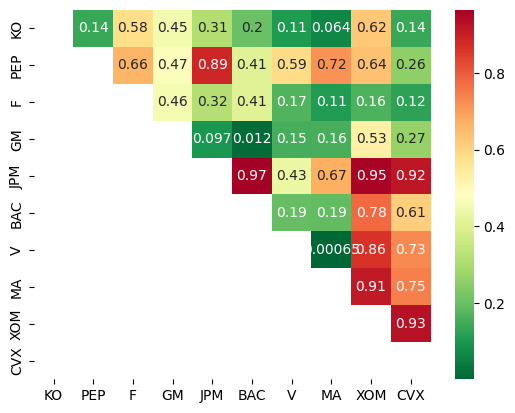

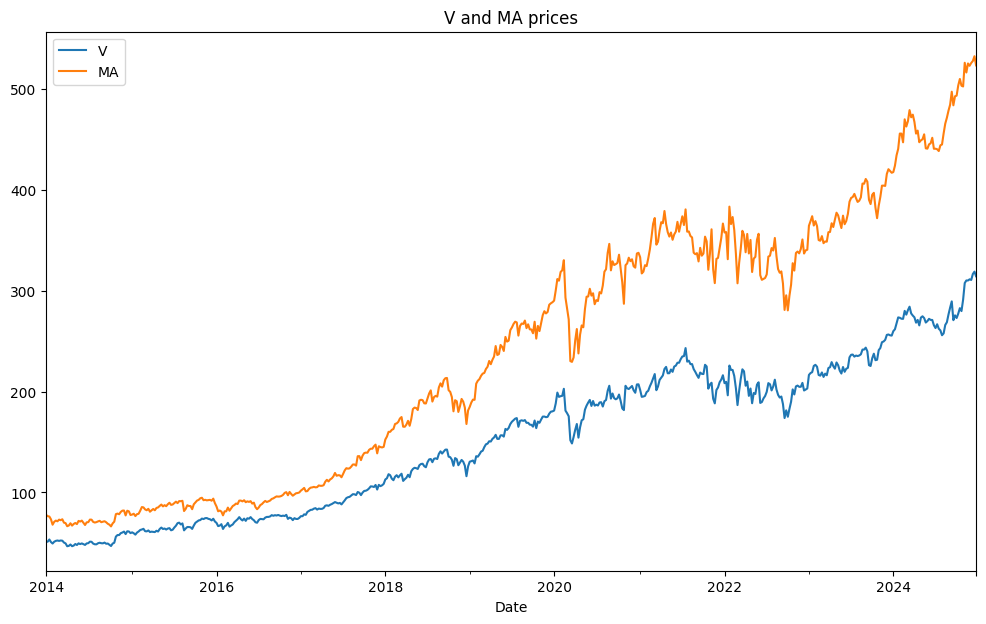

In [8]:
from statsmodels.tsa.stattools import coint
import seaborn

def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.01:   #we choose p-value level at 1%
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

pvalues, pairs = find_cointegrated_pairs(data)
print(pairs)

sns_plot=seaborn.heatmap(pvalues, xticklabels=data.keys(),
                yticklabels=tickers, cmap='RdYlGn_r',annot=True,
                   mask = (pvalues >= 0.98))
fig=sns_plot.get_figure()
fig.savefig('correlation.jpg')
plt.show()

# We've chose Visa (V) and Mastercard (MA) as our pair,

Symbol1_prices = data['V']
Symbol2_prices = data['MA']

plt.title("V and MA prices")

Symbol1_prices.plot(figsize=(12,7))
Symbol2_prices.plot()

plt.legend()
plt.savefig('V+MA.jpg')
plt.show()

#### 3. Use Z-score to identify the trading signals

0.0006471227841374319


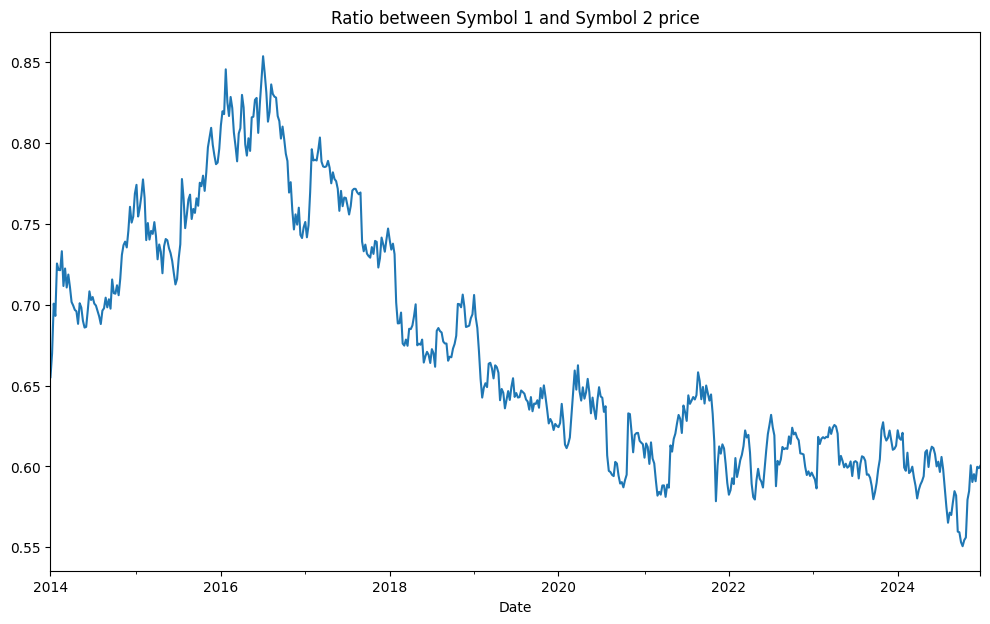

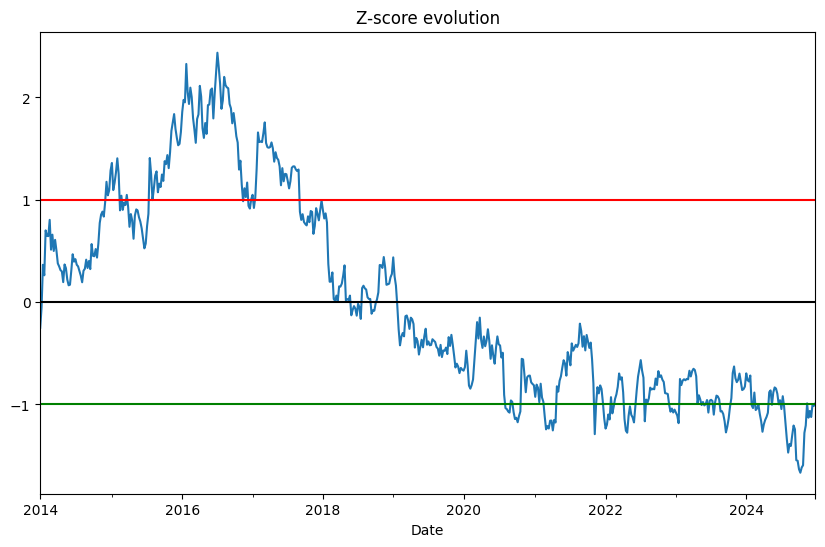

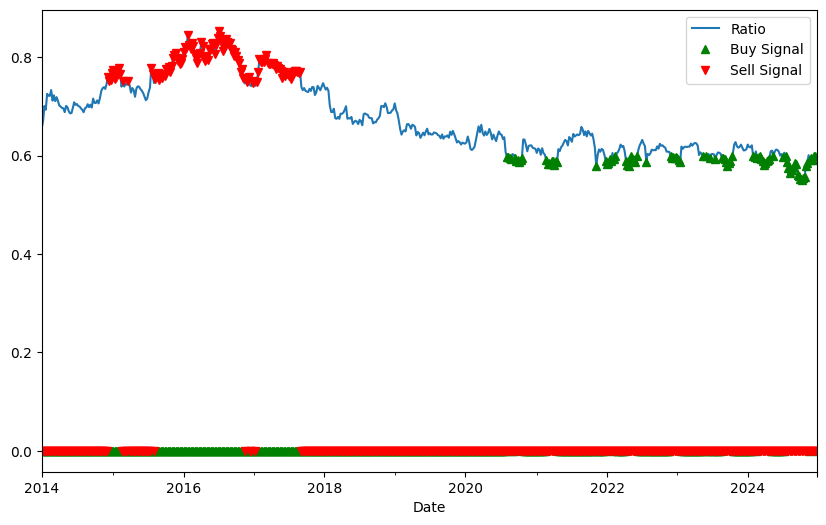

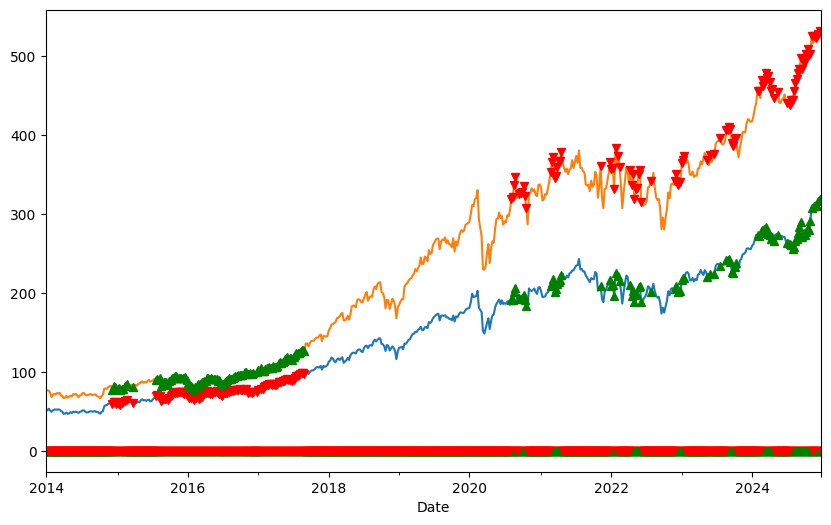

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

score, pvalue, _ = coint(Symbol1_prices, Symbol2_prices)
print(pvalue)
ratios = Symbol1_prices / Symbol2_prices
plt.title("Ratio between Symbol 1 and Symbol 2 price")

ratios.plot(figsize=(12,7))
plt.show()

#Choose k=1
zscore(ratios).plot(figsize=(10,6))
plt.title("Z-score evolution")
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()

ratios.plot(figsize=(10,6))
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

# Identify the buy and sell signals on the price chart of both stocks

symbol1_buy=Symbol1_prices.copy()
symbol1_sell=Symbol1_prices.copy()
symbol2_buy=Symbol2_prices.copy()
symbol2_sell=Symbol2_prices.copy()

Symbol1_prices.plot(figsize=(15,10))
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")

Symbol2_prices.plot(figsize=(10,6))
symbol2_buy[zscore(ratios)<1] = 0
symbol2_sell[zscore(ratios)>-1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")
plt.savefig('MSFT-ADBE-buy-sell.jpg')
plt.show()

#### 4. Backtest the strategy.

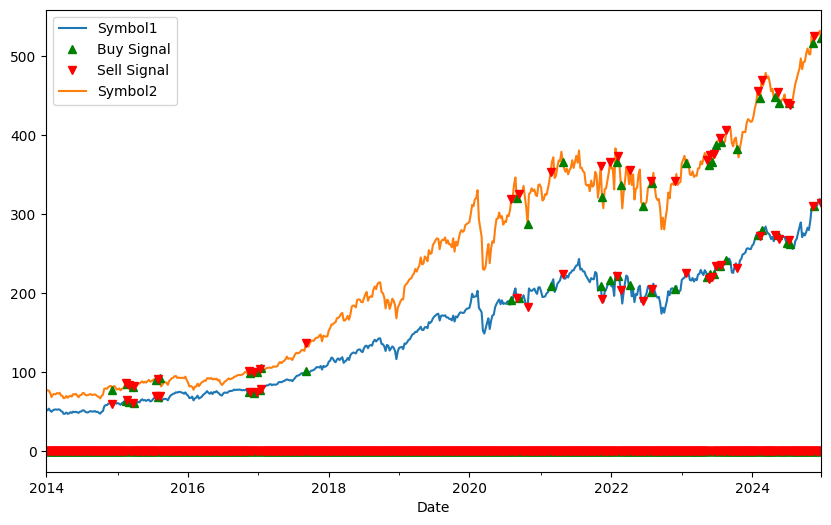

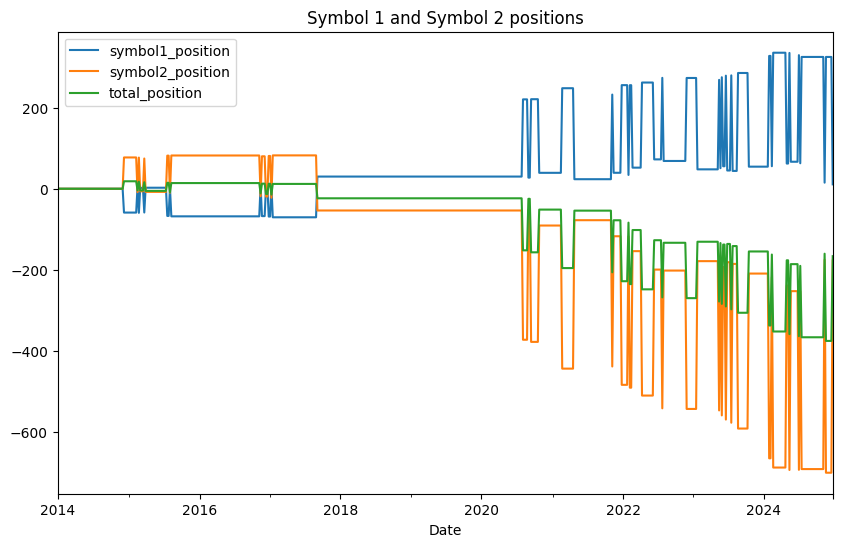

In [10]:
# Backtest the strategy, code borrowed from 'MMA823 - Session 4 - PairTrading-Demo.ipynb'

pair_correlation_trading_strategy = pd.DataFrame(index=Symbol1_prices.index)
pair_correlation_trading_strategy["symbol1_price"] = Symbol1_prices
pair_correlation_trading_strategy["symbol1_buy"] = np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy["symbol1_sell"] = np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy["symbol2_buy"] = np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy["symbol2_sell"] = np.zeros(len(Symbol1_prices))


position = 0
for i in range(len(Symbol1_prices)):
    s1price = Symbol1_prices[i]
    s2price = Symbol2_prices[i]
    if not position and symbol1_buy[i] != 0:
        pair_correlation_trading_strategy["symbol1_buy"][i] = s1price
        pair_correlation_trading_strategy["symbol2_sell"][i] = s2price
        position = 1
    elif not position and symbol1_sell[i] != 0:
        pair_correlation_trading_strategy["symbol1_sell"][i] = s1price
        pair_correlation_trading_strategy["symbol2_buy"][i] = s2price
        position = -1
    elif position == -1 and (symbol1_sell[i] == 0 or i == len(Symbol1_prices) - 1):
        pair_correlation_trading_strategy["symbol1_buy"][i] = s1price
        pair_correlation_trading_strategy["symbol2_sell"][i] = s2price
        position = 0
    elif position == 1 and (symbol1_buy[i] == 0 or i == len(Symbol1_prices) - 1):
        pair_correlation_trading_strategy["symbol1_sell"][i] = s1price
        pair_correlation_trading_strategy["symbol2_buy"][i] = s2price
        position = 0

Symbol1_prices.plot(figsize=(10, 6))
pair_correlation_trading_strategy["symbol1_buy"].plot(
    color="g", linestyle="None", marker="^"
)
pair_correlation_trading_strategy["symbol1_sell"].plot(
    color="r", linestyle="None", marker="v"
)
Symbol2_prices.plot()
pair_correlation_trading_strategy["symbol2_buy"].plot(
    color="g", linestyle="None", marker="^"
)
pair_correlation_trading_strategy["symbol2_sell"].plot(
    color="r", linestyle="None", marker="v"
)

plt.legend(["Symbol1", "Buy Signal", "Sell Signal", "Symbol2"])
plt.savefig("V-MA-pair-strategy.jpg")
plt.show()

# Position
# Assume that we only buy/sell one share, regardless of the price deifference
pair_correlation_trading_strategy["symbol1_position"] = (
    pair_correlation_trading_strategy["symbol1_buy"]
    - pair_correlation_trading_strategy["symbol1_sell"]
)

pair_correlation_trading_strategy["symbol2_position"] = (
    pair_correlation_trading_strategy["symbol2_buy"]
    - pair_correlation_trading_strategy["symbol2_sell"]
)

pair_correlation_trading_strategy["symbol1_position"].cumsum().plot(figsize=(15, 10))
pair_correlation_trading_strategy["symbol2_position"].cumsum().plot(figsize=(15, 10))

pair_correlation_trading_strategy["total_position"] = (
    pair_correlation_trading_strategy["symbol1_position"]
    + pair_correlation_trading_strategy["symbol2_position"]
)
pair_correlation_trading_strategy["total_position"].cumsum().plot(figsize=(10, 6))
plt.title("Symbol 1 and Symbol 2 positions")
plt.legend()
plt.show()

This code backtests a pair trading strategy between two correlated assets by simulating buy and sell signals over time. It initializes a DataFrame to track both symbols’ prices and trade actions, then iterates through each time step to open or close positions based on precomputed buy/sell signals (symbol1_buy and symbol1_sell). When a trade is triggered, it buys one symbol and sells the other to maintain a market-neutral position, switching between long, short, and flat states as signals change. The script then plots both price series with buy/sell markers, visualizing trade timing, and computes cumulative positions for each symbol and the combined portfolio to show the overall exposure and performance of the strategy.